##Importing the necessary packages


In [1]:
import numpy as np
import pandas as pd
import time
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LeakyReLU, Dense, Bidirectional, Activation, Flatten, Dropout
from keras.layers import Conv2DTranspose, Conv2D, LSTM, BatchNormalization, MaxPooling2D, Reshape
from keras.utils import to_categorical
from keras.regularizers import L1L2
from keras.initializers import lecun_uniform
from keras.optimizers import Adam
from keras.metrics import categorical_accuracy
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [155]:
%cd "/content/drive/MyDrive/ECE247-Project"
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

/content/drive/.shortcut-targets-by-id/1ELPC9CkLUbTPdE0JP9VLaPzrtY2b7Uf_/ECE247-Project


In [156]:
# setup tensorflow + TPU 
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.11.0
Running on TPU  ['10.101.90.138:8470']


##Loading and visualizing the dataset 

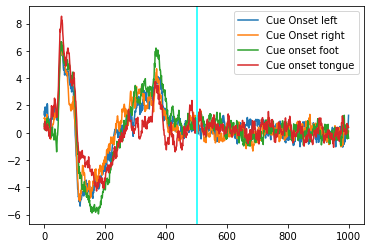

In [157]:
## Loading and visualizing the data

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [158]:
#Numpy and Keras Random Seed Assignment
np.random.seed(1)
k_initializer = lecun_uniform(seed=42)

In [159]:
def data_prep(X, y, sub_sample, average, noise, max_timeStep=500, debug_mode=False):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,max_timeStep)
    X = X[:,:,0:max_timeStep]
    if debug_mode: print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    if debug_mode: print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    if debug_mode: print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    if debug_mode: print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


# X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid, y_train_valid, 2, 2, True, 1000, True)

##Preparing the training, validation, and test datasets

In [160]:
## Random splitting and reshaping the data
def data_train_valid_test_split(sub_sample=2, average=2, noise=True, sobject_id=None, max_timeStep=500, debug_mode=False):

  # Check if we are generating the model for the whole subject
  if sobject_id:
    X_train_sub = X_train_valid[np.where(person_train_valid == sobject_id)[0]]
    y_train_sub = y_train_valid[np.where(person_train_valid == sobject_id)[0]]
    X_test_sub = X_test[np.where(person_test == sobject_id)[0]]
    y_test_sub = y_test[np.where(person_test == sobject_id)[0]]
  else:
    X_train_sub = np.copy(X_train_valid)
    y_train_sub = np.copy(y_train_valid)
    X_test_sub = np.copy(X_test)
    y_test_sub = np.copy(y_test)

  # First generating the training and validation indices using random splitting
  # Since the ratio of test set to the whole training set is about 17%, we chose
  # the same ratio for spliting the training and validation set
  n_train_valid = X_train_sub.shape[0]
  n_valid = int(np.floor(0.17*n_train_valid))
  ind_valid = np.random.choice(n_train_valid, n_valid, replace=False)
  ind_train = np.array(list(set(range(n_train_valid)).difference(set(ind_valid))))

  # Creating the training and validation sets using the generated indices
  (X_train, X_valid) = X_train_sub[ind_train], X_train_sub[ind_valid] 
  (y_train, y_valid) = y_train_sub[ind_train], y_train_sub[ind_valid]


  ## Preprocessing the dataset
  x_train,y_train = data_prep(X_train, y_train, sub_sample, average, noise, max_timeStep, debug_mode)
  x_valid,y_valid = data_prep(X_valid, y_valid, sub_sample, average, noise, max_timeStep, debug_mode)
  X_test_prep,y_test_prep = data_prep(X_test_sub, y_test_sub, sub_sample, average, noise, max_timeStep, debug_mode)

  if debug_mode:
    print('Shape of testing set:',X_test_prep.shape)
    print('Shape of testing labels:',y_test_prep.shape)

    print('Shape of training set:',x_train.shape)
    print('Shape of validation set:',x_valid.shape)
    print('Shape of training labels:',y_train.shape)
    print('Shape of validation labels:',y_valid.shape)


  # Converting the labels to categorical variables for multiclass classification
  y__train = to_categorical(y_train, 4)
  y__valid = to_categorical(y_valid, 4)
  y__test = to_categorical(y_test_prep, 4)

  if debug_mode:
    print('Shape of training labels after categorical conversion:',y_train.shape)
    print('Shape of validation labels after categorical conversion:',y_valid.shape)
    print('Shape of test labels after categorical conversion:',y_test.shape)

  # Adding width of the segment to be 1
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
  x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
  x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
  if debug_mode:
    print('Shape of training set after adding width info:',x_train.shape)
    print('Shape of validation set after adding width info:',x_valid.shape)
    print('Shape of test set after adding width info:',x_test.shape)


  # Reshaping the training and validation dataset
  x__train = np.swapaxes(x_train, 1,3)
  x__train = np.swapaxes(x__train, 1,2)
  x__valid = np.swapaxes(x_valid, 1,3)
  x__valid = np.swapaxes(x__valid, 1,2)
  x__test = np.swapaxes(x_test, 1,3)
  x__test = np.swapaxes(x__test, 1,2)
  
  if debug_mode:
    print('Shape of training set after dimension reshaping:',x__train.shape)
    print('Shape of validation set after dimension reshaping:',x__valid.shape)
    print('Shape of test set after dimension reshaping:',x__test.shape)

  return x__train, y__train, x__valid, y__valid, x__test, y__test


In [161]:
# Generating Train, Validation, and Test data set
x__train, y__train, x__valid, y__valid, x__test, y__test = data_train_valid_test_split(sub_sample=2, average=2, noise=True, sobject_id=None, max_timeStep=1000, debug_mode=True)


Shape of X after trimming: (1756, 22, 1000)
Shape of X after maxpooling: (1756, 22, 500)
Shape of X after averaging+noise and concatenating: (3512, 22, 500)
Shape of X after subsampling and concatenating: (7024, 22, 500)
Shape of X after trimming: (359, 22, 1000)
Shape of X after maxpooling: (359, 22, 500)
Shape of X after averaging+noise and concatenating: (718, 22, 500)
Shape of X after subsampling and concatenating: (1436, 22, 500)
Shape of X after trimming: (443, 22, 1000)
Shape of X after maxpooling: (443, 22, 500)
Shape of X after averaging+noise and concatenating: (886, 22, 500)
Shape of X after subsampling and concatenating: (1772, 22, 500)
Shape of testing set: (1772, 22, 500)
Shape of testing labels: (1772,)
Shape of training set: (7024, 22, 500)
Shape of validation set: (1436, 22, 500)
Shape of training labels: (7024,)
Shape of validation labels: (1436,)
Shape of training labels after categorical conversion: (7024,)
Shape of validation labels after categorical conversion: (1

#(CNN)

##(CNN) Defining the architecture of a basic CNN model

In [162]:
def CNN(initializer, max_timeStep=500, debug_mode=False, learning_rate=1e-3):
  # Building the CNN model using sequential class
  basic_cnn_model = Sequential()

  # Conv. block 1
  basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(int(max_timeStep/2),1,22)))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) 
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))

  # Conv. block 2
  basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))

  # Conv. block 3
  basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))

  # Conv. block 4
  basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))

  # Output layer with Softmax activation
  basic_cnn_model.add(Flatten()) # Flattens the input
  basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

  # Printing the model summary
  if debug_mode:
    basic_cnn_model.summary()

  cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  # Compiling the model
  basic_cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=cnn_optimizer,
                  metrics=['accuracy'])

  return basic_cnn_model

##(CNN) Compiling, training and validating the model

In [163]:
n_epochs=100

# Creating and compiling the model
basic_cnn_model = CNN(k_initializer, max_timeStep=1000, debug_mode=True)

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x__train,
            y__train,
            batch_size=64,
            epochs=n_epochs,
            validation_data=(x__valid, y__valid), verbose=True) 

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 500, 1, 25)        5525      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 167, 1, 25)       0         
 g2D)                                                            
                                                                 
 batch_normalization_60 (Bat  (None, 167, 1, 25)       100       
 chNormalization)                                                
                                                                 
 dropout_60 (Dropout)        (None, 167, 1, 25)        0         
                                                                 
 conv2d_61 (Conv2D)          (None, 167, 1, 50)        12550     
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 56, 1, 50)      

##(CNN) Visualizing the accuracy and loss trajectory

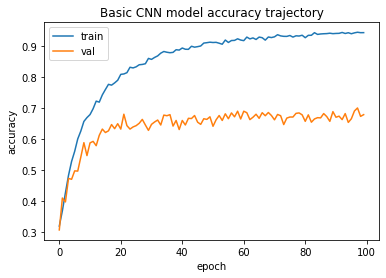

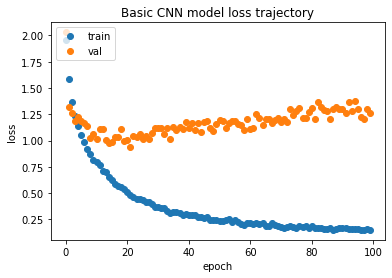

In [164]:
# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##(CNN) Testing the performance of the basic CNN model on the held out test set



In [165]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x__test, y__test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.6873589158058167
